## 1. Setup

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from surrogate_model_functions import plot_3d_model, loo_error
from summit.strategies import TSEMO
from summit.models import GPyModel
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable,ContinuousVariable
from summit.initial_design import LatinDesigner
# from summit.optimizers import EnumerationOptimizer
# from summit.objective import HV

import GPy
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
#Read in solubility data
solubilities = pd.read_csv('inputs/solubilities.csv')
solubilities = solubilities.set_index('cas_number')
solubilities = DataSet.from_df(solubilities)

#Merge data sets
solvent_ds_full = solvent_ds.join(solubilities)
solvent_ds_final = pd.merge(solvent_ds_full, ucb_ds, left_index=True,right_index=True)
print(f"{solvent_ds_final.shape[0]} solvents for optimization")

#Double check that there are no NaNs in the descriptors
values = solvent_ds_final.data_to_numpy()
values = values.astype(np.float64)
check = np.isnan(values)
assert check.all() == False

#Transform to principal componets
num_components = 3
pca = PCA(n_components=num_components)
pca.fit(solvent_ds_full.standardize())
pcs = pca.fit_transform(solvent_ds_final.standardize())
explained_var = round(pca.explained_variance_ratio_.sum()*100)
expl = f"{explained_var}% of variance is explained by {num_components} principal components."
print(expl)

#Create a new dataset with just the principal components
metadata_df = solvent_ds_final.loc[:, solvent_ds_final.metadata_columns]
pc_df = pd.DataFrame(pcs, columns = [f'PC_{i+1}' for i in range(num_components)], 
                     index=metadata_df.index)
pc_ds = DataSet.from_df(pc_df)
solvent_ds_pcs = pd.concat([metadata_df, pc_ds], axis=1)

80 solvents for optimization
68.0% of variance is explained by 3 principal components.


In [265]:
# Set up test problem
AD1 = 8.5
AD2 = 0.7
EAD1 = 50
EAD2 = 70
R = 8.314
cd1 = lambda t, T, Es: AD1*t*np.exp(-(EAD1+Es)/T)
cd2 = lambda t, T, Es: AD2*t*np.exp(-(EAD2+Es)/T)
Es1 = lambda pc1, pc2, pc3: -20*pc2*abs(pc3) + 0.025*pc1**3
Es2 = lambda pc1, pc2, pc3: 15*pc2*pc3-40*pc3**2

def experiment(solvent_cas, random_state=np.random.RandomState()):
    pc_solvent = solvent_ds_pcs.loc[solvent_cas][solvent_ds_pcs.data_columns].to_numpy()
    es1 = Es1(pc_solvent[0], pc_solvent[1], pc_solvent[2])
    es2 = Es2(pc_solvent[0], pc_solvent[1], pc_solvent[2])
    T = 5 * random_state.randn(1) + 393
    t = 0.1 * random_state.randn(1) + 7
    exper_cd1 = cd1(t, T, es1)
    exper_cd2 = cd2(t, T, es2)
#     print(f"es1: {es1}, es2: {es2}, cd1:{round(exper_cd1[0])}, cd2: {round(exper_cd2[0])}")
    conversion = exper_cd1 + exper_cd2
    max_value = 95.0 + random_state.randn(1)*2
    conversion = min(max_value[0], conversion[0])
    converison = conversion + random_state.randn(1)*2  #Analysis noise
    de = abs(exper_cd1-exper_cd2)/(exper_cd1 +exper_cd2)
    de = min(1, de[0])
    de = de + random_state.randn(1)*0.02
    return np.array([conversion, de*100])

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name,PC_1,PC_2,PC_3
cas_number,,,,,,,,
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,Alcohol,Glycerol,5.691078,3.500596,4.144049
98-08-8,trifluoromethylbenzene,trifluoromethylbenzene,C7H5F3,Aromatic,Trifluorotoluene,-1.593723,1.461590,0.320436


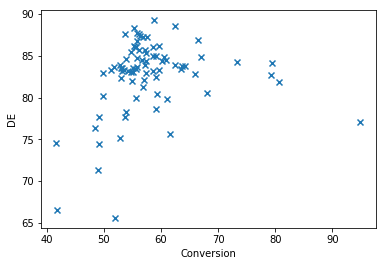

In [266]:
#Visualize values for all solvents
random_state = np.random.RandomState(1000)
all_experiments = [experiment(cas, random_state) for cas in solvent_ds_pcs.index.values]
all_experiments = np.array(all_experiments)
ax = plt.subplot(111)
ax.set_xlabel('Conversion'); ax.set_ylabel('DE')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x')
max_idx = np.argmax(all_experiments, axis=0)
solvent_ds_pcs.iloc[max_idx, :]

In [93]:
random_state = np.random.RandomState(1000)

In [175]:
#Create up optimization domain
domain = Domain()
domain += DescriptorsVariable(name='solvent',
                             description='solvent for the borrowing hydrogen reaction',
                             ds=solvent_ds_pcs)
domain += ContinuousVariable(name='conversion',
                             description='relative conversion to triphenylphosphine oxide determined by LCMS',
                             bounds=[0, 100],
                             is_output=True)
domain += ContinuousVariable(name='de',
                             description='diastereomeric excess determined by ratio of LCMS peaks',
                             bounds=[0, 100],
                             is_output=True)
domain

Name,Type,Description,Values
solvent,"descriptors, input",solvent for the borrowing hydrogen reaction,80 examples of 3 descriptors
conversion,"continuous, output",relative conversion to triphenylphosphine oxide determined by LCMS,"[0,100]"
de,"continuous, output",diastereomeric excess determined by ratio of LCMS peaks,"[0,100]"


In [176]:
#Initial design
lhs = LatinDesigner(domain,random_state)
initial_design = lhs.generate_experiments(8)
initial_design

,cas_number
0,7732-18-5
1,96-49-1
2,680-31-9
3,75-09-2
4,111-87-5
5,108-10-1
6,7226-23-5
7,76-05-1


In [177]:
#Initial experiments
initial_experiments = [experiment(cas, random_state) 
                       for cas in initial_design.to_frame()['cas_number']]
initial_experiments = pd.DataFrame(initial_experiments, columns=['conversion', 'de'])
initial_experiments = DataSet.from_df(initial_experiments)
design_df = initial_design.to_frame()
design_df = design_df.rename(index=int, columns={'cas_number': 'solvent'})
design_ds = DataSet.from_df(design_df)
initial_experiments = initial_experiments.merge(design_ds, left_index=True, right_index=True)
initial_experiments

,conversion,de,solvent
0,67.211274,55.276510,7732-18-5
1,69.232184,51.005413,96-49-1
2,71.611478,48.770228,680-31-9
3,69.869453,48.648067,75-09-2
4,69.948767,48.827642,111-87-5
5,69.777934,48.770812,108-10-1
6,71.169672,48.580118,7226-23-5
7,70.761078,49.220000,76-05-1


In [178]:
#Run the optimization
input_dim = domain.num_continuous_dimensions() +domain.num_discrete_variables()
kernels = [GPy.kern.Matern52(input_dim = input_dim, ARD=True)
           for _ in range(2)]
models = [GPyModel(kernel=kernels[i]) for i in range(2)]
# tsemo = TSEMO(domain, models, acquisition=HV(), optimizer=EnumerationOptimizer())
tsemo = TSEMO(domain, models)
design = tsemo.generate_experiments(initial_experiments, 8, 
                                    normalize=True, num_spectral_samples=500)
design

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name,PC_1,PC_2,PC_3
cas_number,,,,,,,,
7732-18-5,water,h2o,H2O,Polar Protic,Water,8.603727,-4.350600,1.697751
142-82-5,heptane,n-heptane,C7H16,Alkane,n-Heptane,-4.810450,-1.227858,1.217925
109-66-0,pentane,pentane,C5H12,Alkane,Pentane,-4.099515,-4.339576,-0.109413
540-84-1,"2,2,4-trimethylpentane","2,2,4-trimethylpentane",C8H18,Alkane,Isooctane,-5.249607,-0.723050,1.303672
110-54-3,hexane,hexane,C6H14,Alkane,Hexane,-4.277656,-2.353620,0.693289
78-92-2,2-butanol,2-butanol,C4H10O,Alcohol,2-Butanol,0.358041,-1.472507,0.368434
75-65-0,2-methyl-2-propanol,tert-butanol,C4H10O,Alcohol,t-Butanol,0.804964,-0.904899,0.662096
110-86-1,pyridine,pyridine,C5H5N,Base,Pyridine,0.460690,0.235414,-0.534104


In [179]:
#Next set of experiments
num_batches = 4
lengthscales = np.zeros([num_batches, num_components, 2])
lengthscales[0, :, :] = np.array([model._model.kern.lengthscale.values for model in models]).T
experiments = initial_experiments.copy()
new_experiments = [experiment(cas, random_state)
                   for cas in design.index.values]
new_experiments = np.array(new_experiments)
new_experiments = DataSet({('conversion', 'DATA'): new_experiments[:, 0],
                           ('de', 'DATA'): new_experiments[:, 1],
                           ('solvent', 'DATA'): design.index.values})
new_experiments = new_experiments.set_index(np.arange(8, 16))
new_experiments.columns.names = ['NAME', 'TYPE']
previous_experiments = initial_experiments.append(new_experiments)
previous_experiments

,conversion,de,solvent
0,67.211274,55.276510,7732-18-5
1,69.232184,51.005413,96-49-1
2,71.611478,48.770228,680-31-9
3,69.869453,48.648067,75-09-2
4,69.948767,48.827642,111-87-5
5,69.777934,48.770812,108-10-1
6,71.169672,48.580118,7226-23-5
7,70.761078,49.220000,76-05-1
8,67.727690,55.359964,7732-18-5
9,72.426823,50.654332,142-82-5


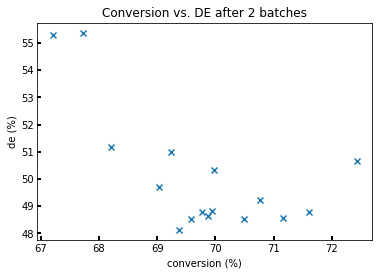

In [180]:
#Visualize the data
fig = plt.figure()
ax = plt.subplot(111)
data = previous_experiments.data_to_numpy()
ax.scatter(data[:, 0], data[:, 1], marker='x')
ax.tick_params(direction='in', length=4, width=2)
plt.xlabel('conversion (%)'); plt.ylabel('de (%)')
plt.title('Conversion vs. DE after 2 batches')
plt.savefig('outputs/in_silico_pareto_2_batches.png')
plt.savefig('outputs/in_silico_pareto_2_batches.svg')
# print(f"Promising solvent: {}")

In [181]:
%debug
for i in range(num_batches):
    tsemo = TSEMO(domain, models)
    design = tsemo.generate_experiments(previous_experiments, 8, 
                                        normalize=False, num_spectral_samples=500)
    new_experiments = [experiment(cas, random_state)
                      for cas in design.index.values]
    new_experiments = np.array(new_experiments)
    new_experiments = DataSet({('conversion', 'DATA'): new_experiments[:, 0],
                               ('de', 'DATA'): new_experiments[:, 1],
                               ('solvent', 'DATA'): design.index.values})
    import ipdb; ipdb.set_trace()
    new_experiments = new_experiments.set_index(np.arange(8*i, 8*(i+1)))
    new_experiments.columns.names = ['NAME', 'TYPE']
    previous_experiments = new_experiments.append(previous_experiments)
    
    lengthscales[i, :, :] = np.array([model._model.kern.lengthscale.values for model in models]).T

> <ipython-input-171-1299ac88b7f2>(9)<lambda>()
      7 cd1 = lambda t, T, Es: AD1*t*np.exp(-(EAD1+Es)/T)
      8 cd2 = lambda t, T, Es: AD2*t*np.exp(-(EAD2+Es)/T)
----> 9 Es1 = lambda pc1, pc2: 1/(pc1-pc3)
     10 Es2 = lambda pc1, pc2, pc3: pc1**2
     11 



ipdb>  n


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


> <ipython-input-181-2b383c52f5ce>(13)<module>()
     12     import ipdb; ipdb.set_trace()
---> 13     new_experiments = new_experiments.set_index(np.arange(8*i, 8*(i+1)))
     14     new_experiments.columns.names = ['NAME', 'TYPE']



ipdb>  new_experiments


  conversion         de   solvent
        DATA       DATA      DATA
0  69.417250  48.613534  107-31-3
1  71.902880  48.847731  108-93-0
2  70.129586  48.610882   67-64-1
3  69.120711  49.772566  109-66-0
4  71.711201  48.643712   71-23-8
5  69.164131  48.716211  591-78-6
6  70.348169  48.651835  102-76-1
7  69.642911  48.100431  110-86-1


ipdb>  q


BdbQuit: 